# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create Files_Name
image_data='/kaggle/input/tyre-quality-classification/Digital images of defective and good condition tyres'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0       good
1  defective

In [3]:
train_data_dir =image_data
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 1856 files belonging to 2 classes.
Using 1485 files for training.
Found 1856 files belonging to 2 classes.
Using 371 files for validation.


# plt

In [4]:
class_names = train.class_names
class_names

['defective', 'good']

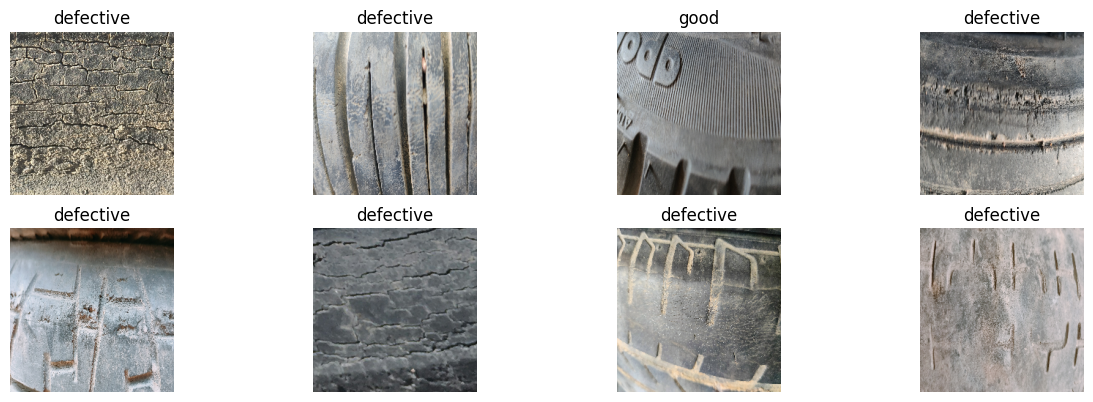

In [5]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model

In [6]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(2,activation=tf.nn.softmax))
keras_model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 995,570
Trainable params: 56,450
Non-trainable params: 939,120
_________________________________________________________________


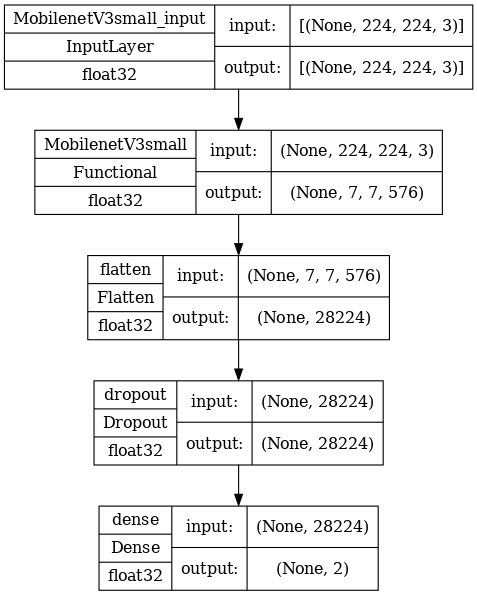

In [7]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [8]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [9]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [10]:
keras_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=10,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/10
47/47 [==============================] - 34s 587ms/step - loss: 0.9600 - accuracy: 0.8290 - val_loss: 0.2722 - val_accuracy: 0.9515
Epoch 2/10
47/47 [==============================] - 26s 485ms/step - loss: 0.2928 - accuracy: 0.9401 - val_loss: 0.1664 - val_accuracy: 0.9730
Epoch 3/10
47/47 [==============================] - 26s 499ms/step - loss: 0.1292 - accuracy: 0.9697 - val_loss: 0.1164 - val_accuracy: 0.9757
Epoch 4/10
47/47 [==============================] - 26s 485ms/step - loss: 0.0920 - accuracy: 0.9798 - val_loss: 0.0817 - val_accuracy: 0.9838
Epoch 5/10
47/47 [==============================] - 25s 478ms/step - loss: 0.0779 - accuracy: 0.9805 - val_loss: 0.0619 - val_accuracy: 0.9892
Epoch 6/10
47/47 [==============================] - 25s 474ms/step - loss: 0.0298 - accuracy: 0.9912 - val_loss: 0.1130 - val_accuracy: 0.9784
Epoch 7/10
47/47 [==============================] - 25s 474ms/step - loss: 0.0494 - accuracy: 0.9845 - val_loss: 0.1617 - val_accuracy: 0.9784

In [11]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 [==============================] - 5s 186ms/step - loss: 0.0619 - accuracy: 0.9892
Test Loss = 0.061923589557409286
Test Accuracy = 0.9892183542251587


In [12]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.960028  0.828956  0.272211      0.951482
1  0.292814  0.940067  0.166415      0.973046
2  0.129162  0.969697  0.116378      0.975741
3  0.092032  0.979798  0.081707      0.983827
4  0.077852  0.980471  0.061924      0.989218
5  0.029807  0.991246  0.112979      0.978437
6  0.049445  0.984512  0.161692      0.978437
7  0.031286  0.988552  0.114308      0.983827
8  0.026884  0.991919  0.160329      0.981132
9  0.035754  0.990572  0.146538      0.981132

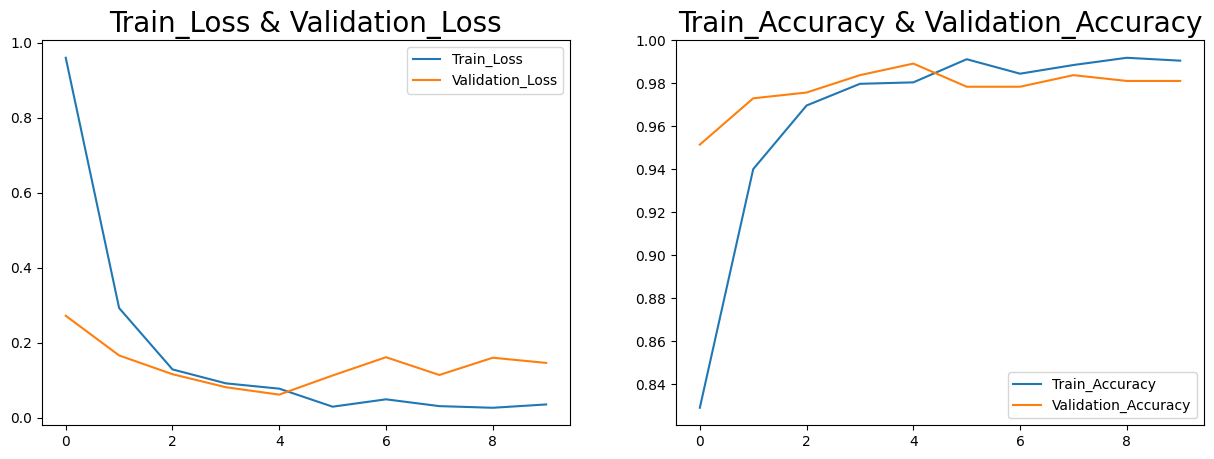

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [14]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

12/12 [==============================] - 2s 128ms/step


Actual  Prediction
0         0           0
1         1           1
2         0           1
3         0           0
4         1           1
..      ...         ...
366       0           0
367       1           1
368       1           1
369       1           1
370       0           0

[371 rows x 2 columns]

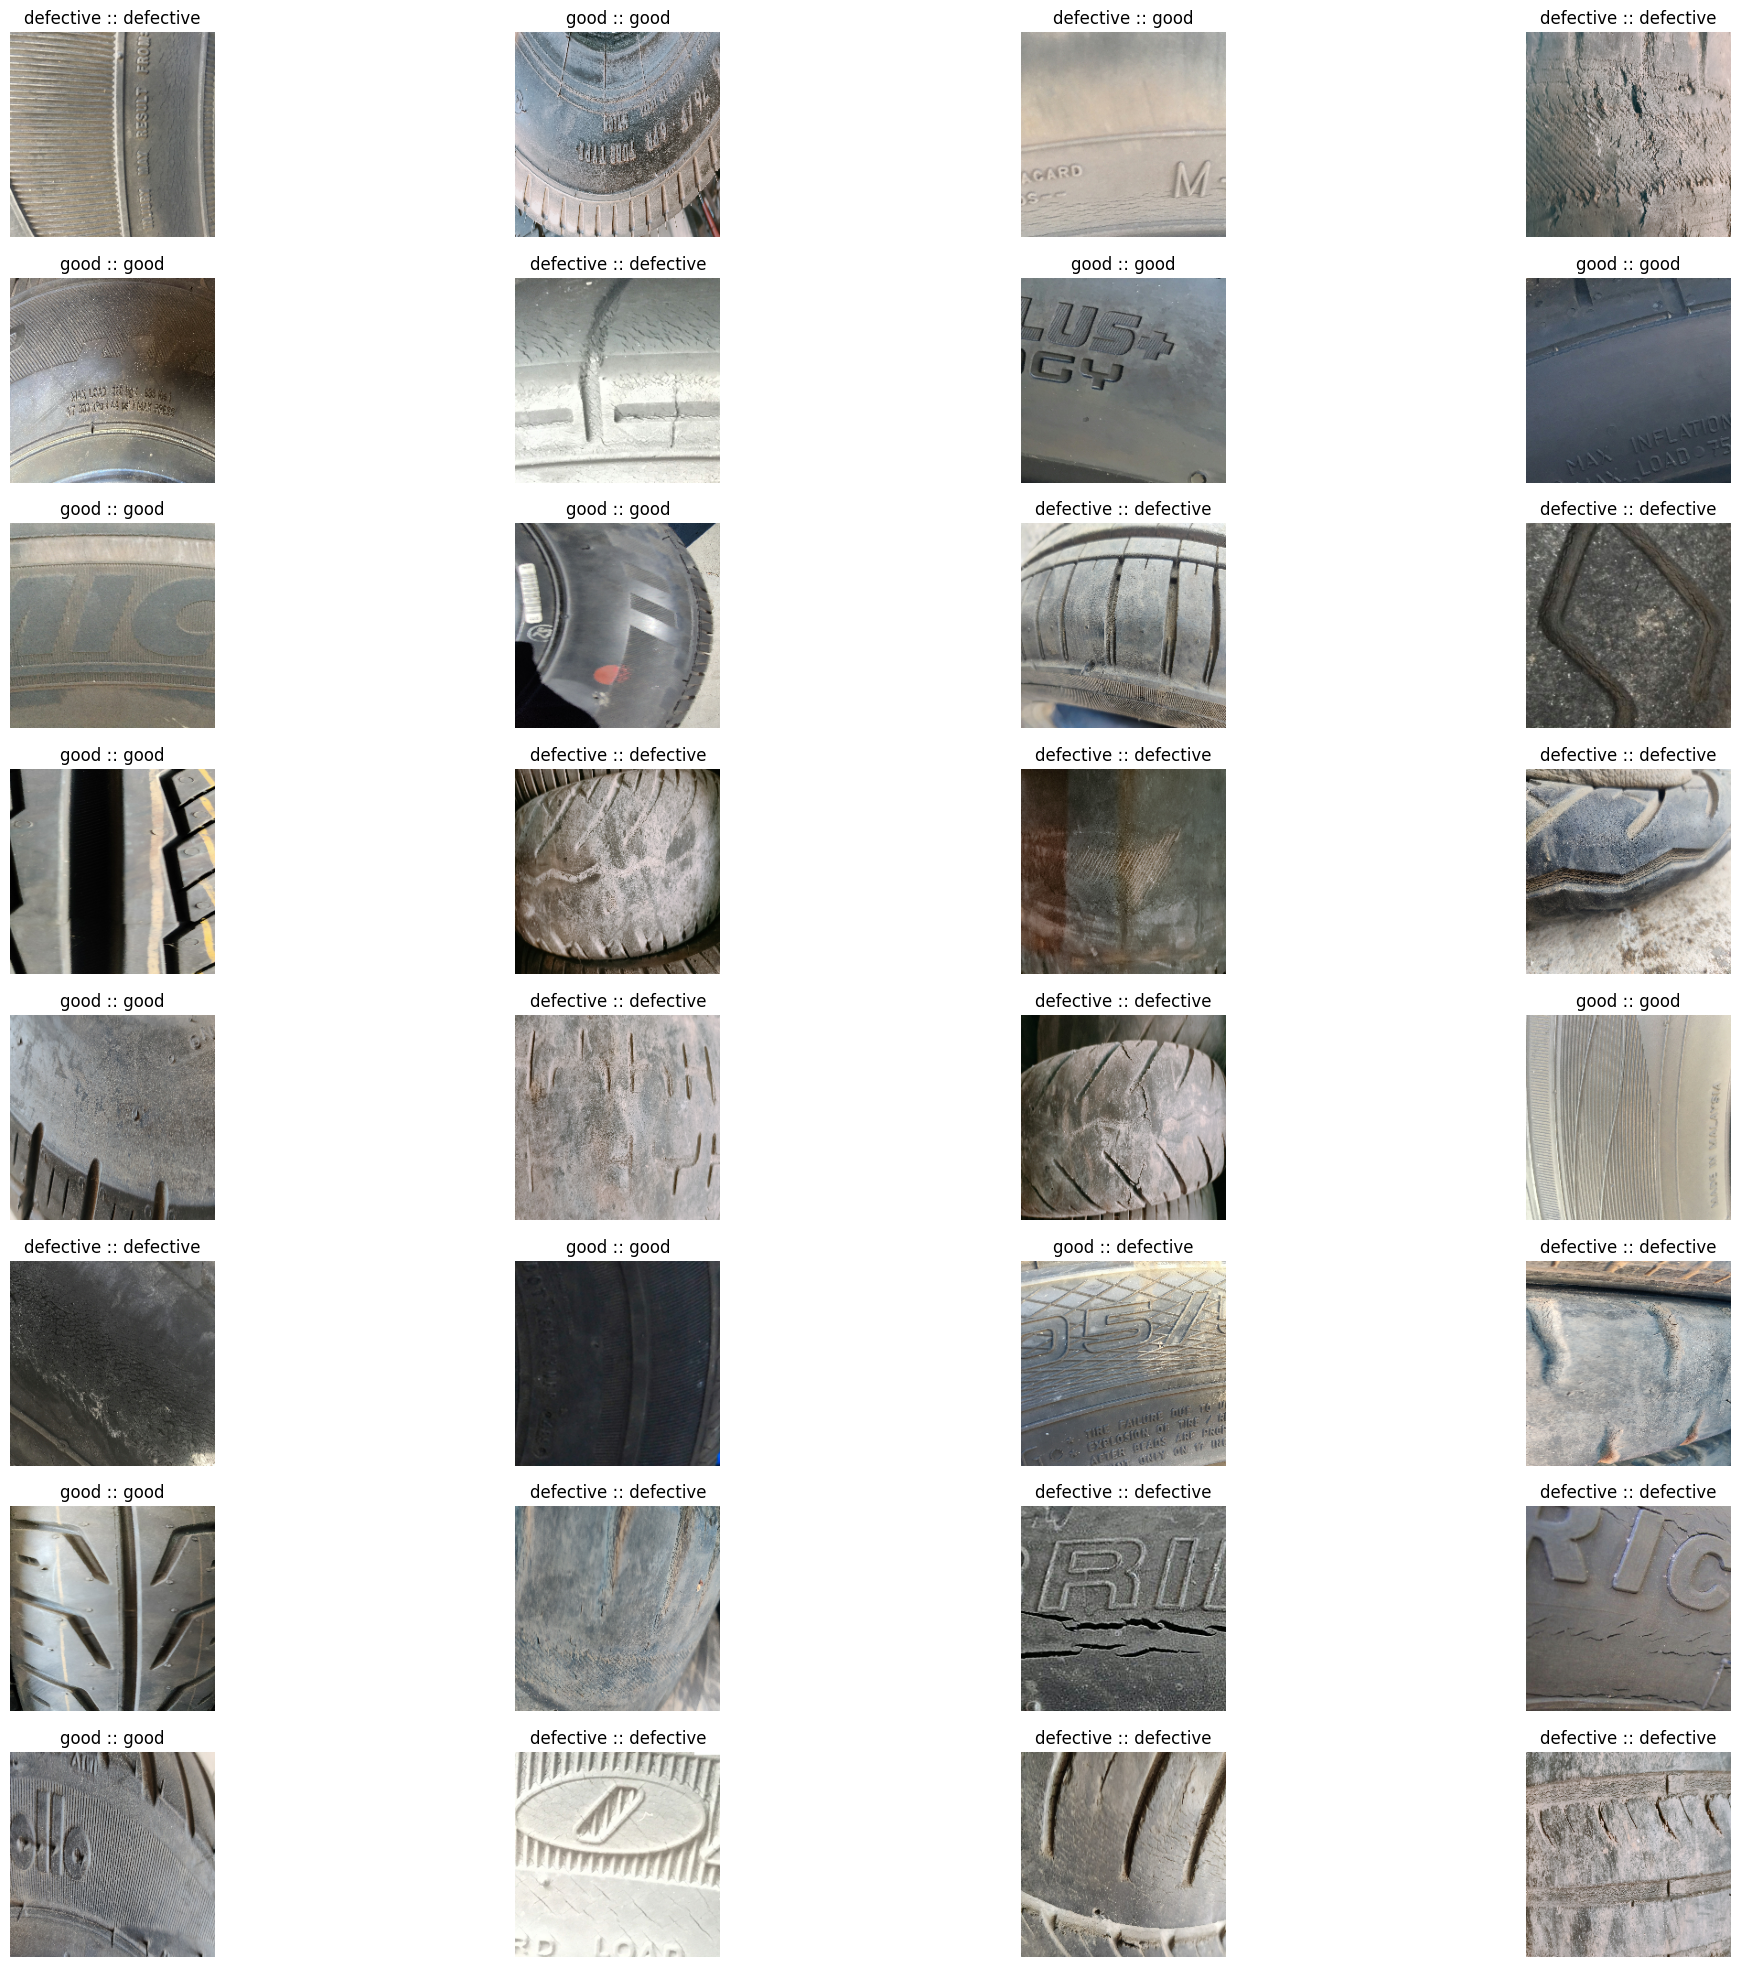

In [15]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

# Confusion_matrix

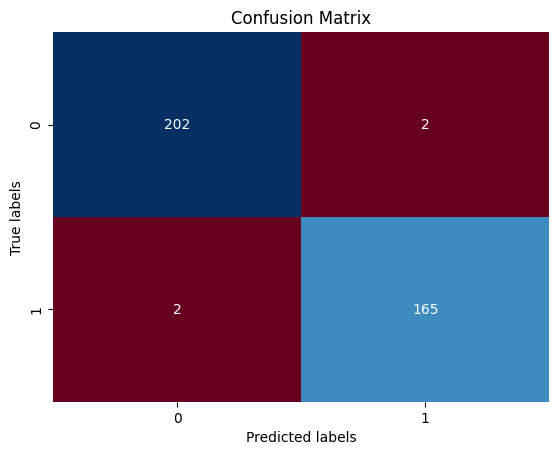

array([[202,   2],
       [  2, 165]])

In [16]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [17]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 98.922%


In [18]:
model.save('tire.h5')

NameError: name 'model' is not defined